The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 629 kB/s 
     |████████████████████████████████| 120 kB 58.5 MB/s 
     |████████████████████████████████| 1.6 MB 52.1 MB/s 
     |████████████████████████████████| 82 kB 801 kB/s 


# Multi-Branch Networks  (GoogLeNet)
:label:`sec_googlenet`

In 2014, *GoogLeNet*
won the ImageNet Challenge :cite:`Szegedy.Liu.Jia.ea.2015`, using a structure
that combined the strengths of NiN :cite:`Lin.Chen.Yan.2013`, repeated blocks :cite:`Simonyan.Zisserman.2014`,
and a cocktail of convolution kernels. It is arguably also the first network that exhibits a clear distinction among the stem (data ingest), body (data processing), and head (prediction) in a CNN. This design pattern has persisted ever since in the design of deep networks: the *stem* is given by the first 2--3 convolutions that operate on the image. They extract low-level features from the underlying images. This is followed by a *body* of convolutional blocks. Finally, the *head* maps the features obtained so far to the required classification, segmentation, detection, or tracking problem at hand.

The key contribution in GoogLeNet was the design of the network body. It solved the problem of selecting
convolution kernels in an ingenious way. While other works tried to identify which convolution, ranging from $1 \times 1$ to $11 \times 11$ would be best, it simply *concatenated* multi-branch convolutions.
In what follows we introduce a slightly simplified version of GoogLeNet: the original design included a number of tricks to stabilize training through intermediate loss functions, applied to multiple layers of the network. 
They are no longer necessary due to the availability of improved training algorithms. 


## (**Inception Blocks**)

The basic convolutional block in GoogLeNet is called an *Inception block*,
stemming from the meme "we need to go deeper" of the movie *Inception*.

![Structure of the Inception block.](http://d2l.ai/_images/inception.svg)
:label:`fig_inception`

As depicted in :numref:`fig_inception`,
the inception block consists of four parallel branches.
The first three branches use convolutional layers
with window sizes of $1\times 1$, $3\times 3$, and $5\times 5$
to extract information from different spatial sizes.
The middle two branches also add a $1\times 1$ convolution of the input
to reduce the number of channels, reducing the model's complexity.
The fourth branch uses a $3\times 3$ max-pooling layer,
followed by a $1\times 1$ convolutional layer
to change the number of channels.
The four branches all use appropriate padding to give the input and output the same height and width.
Finally, the outputs along each branch are concatenated
along the channel dimension and comprise the block's output.
The commonly-tuned hyperparameters of the Inception block
are the number of output channels per layer, i.e., how to allocate capacity among convolutions of different size.


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

To gain some intuition for why this network works so well,
consider the combination of the filters.
They explore the image in a variety of filter sizes.
This means that details at different extents
can be recognized efficiently by filters of different sizes.
At the same time, we can allocate different amounts of parameters
for different filters.


## [**GoogLeNet Model**]

As shown in :numref:`fig_inception_full`, GoogLeNet uses a stack of a total of 9 inception blocks, arranged into 3 groups with max-pooling in between,
and global average pooling in its head to generate its estimates.
Max-pooling between inception blocks reduces the dimensionality.
At its stem, the first module is similar to AlexNet and LeNet.

![The GoogLeNet architecture.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/inception-full-90.svg?raw=1)
:label:`fig_inception_full`

We can now implement GoogLeNet piece by piece. Let's begin with the stem.
The first module uses a 64-channel $7\times 7$ convolutional layer.


In [3]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The second module uses two convolutional layers:
first, a 64-channel $1\times 1$ convolutional layer,
followed by a $3\times 3$ convolutional layer that triples the number of channels. This corresponds to the second branch in the Inception block and concludes the design of the body. At this point we have 192 channels.


In [4]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The third module connects two complete Inception blocks in series.
The number of output channels of the first Inception block is
$64+128+32+32=256$. This amounts to 
a ratio of the number of output channels
among the four branches of $2:4:1:1$. Achieving this, we first reduce the input
dimensions by $\frac{1}{2}$ and by $\frac{1}{12}$ in the second and third branch respectively
to arrive at $96 = 192/2$ and $16 = 192/12$ channels respectively.

The number of output channels of the second Inception block
is increased to $128+192+96+64=480$, yielding a ratio of $128:192:96:64 = 4:6:3:2$. As before,
we need to reduce the number of intermediate dimensions in the second and third channel. A
scale of $\frac{1}{2}$ and $\frac{1}{8}$ respectively suffices, yielding $128$ and $32$ channels
respectively. This is captured by the arguments of the following `Inception` block constructors.


In [5]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fourth module is more complicated.
It connects five Inception blocks in series,
and they have $192+208+48+64=512$, $160+224+64+64=512$,
$128+256+64+64=512$, $112+288+64+64=528$,
and $256+320+128+128=832$ output channels, respectively.
The number of channels assigned to these branches is similar
to that in the third module:
the second branch with the $3\times 3$ convolutional layer
outputs the largest number of channels,
followed by the first branch with only the $1\times 1$ convolutional layer,
the third branch with the $5\times 5$ convolutional layer,
and the fourth branch with the $3\times 3$ max-pooling layer.
The second and third branches will first reduce
the number of channels according to the ratio.
These ratios are slightly different in different Inception blocks.


In [6]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fifth module has two Inception blocks with $256+320+128+128=832$
and $384+384+128+128=1024$ output channels.
The number of channels assigned to each branch
is the same as that in the third and fourth modules,
but differs in specific values.
It should be noted that the fifth block is followed by the output layer.
This block uses the global average pooling layer
to change the height and width of each channel to 1, just as in NiN.
Finally, we turn the output into a two-dimensional array
followed by a fully connected layer
whose number of outputs is the number of label classes.


In [7]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

Now that we defined all blocks `b1` through `b5`, it's just a matter of assembling them all into a full network.


In [8]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

The GoogLeNet model is computationally complex. Note the large number of
relatively arbitrary hyperparameters in terms of the number of channels chosen, the number of blocks prior to dimensionality reduction, the relative partitioning of capacity across channels, etc. Much of it is due to the 
fact that at the time when GoogLeNet was introduced, automatic tools for network definition or design exploration 
were not yet available. For instance, by now we take it for granted that a competent deep learning framework is capable of inferring dimensionalities of input tensors automatically. At the time, many such configurations had to be specified explicitly by the experimenter, thus often slowing down active experimentation. Moreover, the tools needed for automatic exploration were still in flux and initial experiments largely amounted to costly brute force exploration, genetic algorithms, and similar strategies. 

For now the only modification we will carry out is to
[**reduce the input height and width from 224 to 96
to have a reasonable training time on Fashion-MNIST.**]
This simplifies the computation. Let's have a look at the
changes in the shape of the output between the various modules.


In [9]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## [**Training**]

As before, we train our model using the Fashion-MNIST dataset.
 We transform it to $96 \times 96$ pixel resolution
 before invoking the training procedure.


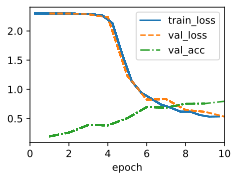

In [10]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Discussion

A key feature of GoogLeNet is that it is actually *cheaper* to compute than its predecessors
while simultaneously providing improved accuracy. This marks the beginning of a much more deliberate
network design that trades off the cost of evaluating a network with a reduction in errors. It also marks the beginning of experimentation at a block level with network design hyperparameters, even though it was entirely manual at the time. We will revisit this topic in :numref:`sec_cnn-design` when discussing strategies for network structure exploration. 

Over the following sections we will encounter a number of design choices (e.g., batch normalization, residual connections, and channel grouping) that allow us to improve networks significantly. For now, you can be proud to have implemented what is arguably the first truly modern CNN.

## Exercises

1. GoogLeNet was so successful that it went through a number of iterations. There are several iterations
   of GoogLeNet that progressively improved speed and accuracy. Try to implement and run some of them.
   They include the following:
   1. Add a batch normalization layer :cite:`Ioffe.Szegedy.2015`, as described
      later in :numref:`sec_batch_norm`.
   1. Make adjustments to the Inception block (width, choice and order of convolutions), as described in
      :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
   1. Use label smoothing for model regularization, as described in
      :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
   1. Make further adjustments to the Inception block by adding residual connection
      :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017`, as described later in
      :numref:`sec_resnet`.
1. What is the minimum image size for GoogLeNet to work?
1. Can you design a variant of GoogLeNet that works on Fashion-MNIST's native resolution of $28 \times 28$ pixels? How would you need to change the stem, the body, and the head of the network, if anything at all?
1. Compare the model parameter sizes of AlexNet, VGG, NiN, and GoogLeNet. How do the latter two network
   architectures significantly reduce the model parameter size?
1. Compare the amount of computation needed in GoogLeNet and AlexNet. How does this affect the design of an accelerator chip, e.g., in terms of memory size, memory bandwidth, cache size, the amount of computation, and the benefit of specialized operations?


[Discussions](https://discuss.d2l.ai/t/82)
